In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Import my Kovaak's data loader
from kovaaks_loader import load_all_kovaaks_data

print(os.getcwd())
csv_dir = "./stats"


/Users/aidansmith/Library/CloudStorage/OneDrive-Personal/DocumentsGrad/Projects/AimTrainerCompanion/KovaaKs-Data-Analysis-Companion


In [2]:
# Load all data
main_data, weapon_data, stats_data = load_all_kovaaks_data(csv_dir)

Processed 10 files...
Processed 20 files...
Processed 30 files...
Processed 40 files...
Processed 50 files...
Processed 60 files...
Processed 70 files...
Processed 80 files...
Processed 90 files...
Processed 100 files...
Processed 110 files...
Processed 120 files...
Processed 130 files...
Processed 140 files...
Processed 150 files...
Processed 160 files...
Processed 170 files...
Processed 180 files...
Processed 190 files...
Processed 200 files...
Processed 210 files...
Processed 220 files...
Processed 230 files...
Processed 240 files...
Processed 250 files...
Processed 260 files...
Processed 270 files...
Processed 280 files...
Processed 290 files...
Processed 300 files...
Processed 310 files...
Processed 320 files...
Processed 330 files...
Processed 340 files...

Total files processed: 343
Unique tasks: 102


# Analyzing Sensitivity

Need to check:
- How many different sensitivities are used (differences in DPI and Sens)
- How inner-task performance difference changes between task type

Should probably primarily focus on eDPI (so dpi * sensitivity)
Maybe at most one general analysis of performance to potentially catch performance losses from low DPI (low dpi -> larger distance before single movement chunk -> potentially worse tracking, smoothness, etc)

In [3]:
from datetime import datetime

# Flatten stats_data into a DataFrame for analysis
rows = []
for task, sessions in stats_data.items():
    for date_str, stats in sessions.items():
        row = {"task": task, "session_time_str": date_str}
        # Parse datetime if possible
        try:
            row["session_time"] = datetime.strptime(date_str, "%Y.%m.%d-%H.%M.%S")
        except Exception:
            row["session_time"] = None
        # Normalize keys (strip trailing commas) and add stats
        for k, v in stats.items():
            key_clean = k.rstrip(',').strip()
            # Also clean values that might still have commas (defensive)
            if isinstance(v, str):
                v = v.strip().lstrip(',').rstrip(',').strip()
                # Try to convert cleaned string to number
                if v:
                    try:
                        if '.' in v:
                            v = float(v)
                        else:
                            v = int(v)
                    except ValueError:
                        pass  # Keep as string
            row[key_clean] = v
        rows.append(row)

stats_df = pd.DataFrame(rows)

print("stats_df shape:", stats_df.shape)
print("\nSensitivity-related columns available:")
sens_cols = [col for col in stats_df.columns if any(x in col.lower() for x in ['sens', 'dpi', 'edpi'])]
print(sens_cols)


stats_df shape: (343, 45)

Sensitivity-related columns available:
['Sens Scale', 'Sens Increment', 'Horiz Sens', 'Vert Sens', 'DPI']


In [4]:
# Extract and clean sensitivity data
sens_df = stats_df[['task', 'session_time_str', 'Horiz Sens', 'Vert Sens', 'DPI', 'Score']].copy()

# Convert to numeric, handling any string values
for col in ['Horiz Sens', 'Vert Sens', 'DPI', 'Score']:
    if col in sens_df.columns:
        sens_df[col] = pd.to_numeric(sens_df[col], errors='coerce')

# Remove rows with missing sensitivity data
sens_df = sens_df.dropna(subset=['Horiz Sens', 'Vert Sens', 'DPI'])

print(f"Total sessions with sensitivity data: {len(sens_df)}")
print(f"Sessions with missing sensitivity data: {len(stats_df) - len(sens_df)}")

# Calculate eDPI (effective DPI = DPI * sensitivity)
# Using horizontal sensitivity as standard (most common approach)
sens_df['eDPI'] = sens_df['DPI'] * sens_df['Horiz Sens']

# Also calculate eDPI using vertical sensitivity for comparison
sens_df['eDPI_Vert'] = sens_df['DPI'] * sens_df['Vert Sens']

# Check for differences between horizontal and vertical sensitivity
sens_df['Sens_Diff'] = abs(sens_df['Horiz Sens'] - sens_df['Vert Sens'])

print(f"\nSessions with different horiz/vert sensitivity: {(sens_df['Sens_Diff'] > 0.01).sum()}")
print(f"Average sensitivity difference: {sens_df['Sens_Diff'].mean():.4f}")

# Display summary statistics
print("\nSensitivity Summary Statistics:")
print(sens_df[['Horiz Sens', 'Vert Sens', 'DPI', 'eDPI', 'Score']].describe())


Total sessions with sensitivity data: 343
Sessions with missing sensitivity data: 0

Sessions with different horiz/vert sensitivity: 0
Average sensitivity difference: 0.0000

Sensitivity Summary Statistics:
       Horiz Sens   Vert Sens          DPI          eDPI         Score
count  343.000000  343.000000   343.000000    343.000000    343.000000
mean     9.373178    9.373178  4265.889213  37476.384840   1668.186461
std      1.817904    1.817904  2176.583851  19044.659634   1915.736245
min      5.000000    5.000000   400.000000   5200.000000     11.000000
25%      8.000000    8.000000  3200.000000  25600.000000    450.000000
50%      9.000000    9.000000  3200.000000  32000.000000    910.500000
75%     10.000000   10.000000  6400.000000  57600.000000   2280.000000
max     15.000000   15.000000  6400.000000  64000.000000  10520.578125


In [5]:
# Count unique sensitivity combinations
# Create a combination key
sens_df['Sens_Combo'] = sens_df.apply(
    lambda x: f"DPI:{x['DPI']:.0f}, H:{x['Horiz Sens']:.2f}, V:{x['Vert Sens']:.2f}", 
    axis=1
)

unique_combos = sens_df['Sens_Combo'].nunique()
print(f"Number of unique sensitivity combinations: {unique_combos}")

# Show the most common combinations
print("\nTop 10 most common sensitivity combinations:")
combo_counts = sens_df['Sens_Combo'].value_counts().head(10)
for combo, count in combo_counts.items():
    print(f"  {combo}: {count} sessions ({count/len(sens_df)*100:.1f}%)")

# Also show unique eDPI values
unique_edpi = sens_df['eDPI'].nunique()
print(f"\nNumber of unique eDPI values: {unique_edpi}")
print(f"eDPI range: {sens_df['eDPI'].min():.0f} - {sens_df['eDPI'].max():.0f}")
print(f"eDPI mean: {sens_df['eDPI'].mean():.0f}, median: {sens_df['eDPI'].median():.0f}")


Number of unique sensitivity combinations: 10

Top 10 most common sensitivity combinations:
  DPI:6400, H:9.00, V:9.00: 121 sessions (35.3%)
  DPI:3200, H:8.00, V:8.00: 91 sessions (26.5%)
  DPI:3200, H:10.00, V:10.00: 44 sessions (12.8%)
  DPI:400, H:13.00, V:13.00: 43 sessions (12.5%)
  DPI:6400, H:8.00, V:8.00: 22 sessions (6.4%)
  DPI:400, H:15.00, V:15.00: 7 sessions (2.0%)
  DPI:6400, H:10.00, V:10.00: 7 sessions (2.0%)
  DPI:6400, H:6.00, V:6.00: 6 sessions (1.7%)
  DPI:6400, H:7.00, V:7.00: 1 sessions (0.3%)
  DPI:6400, H:5.00, V:5.00: 1 sessions (0.3%)

Number of unique eDPI values: 9
eDPI range: 5200 - 64000
eDPI mean: 37476, median: 32000


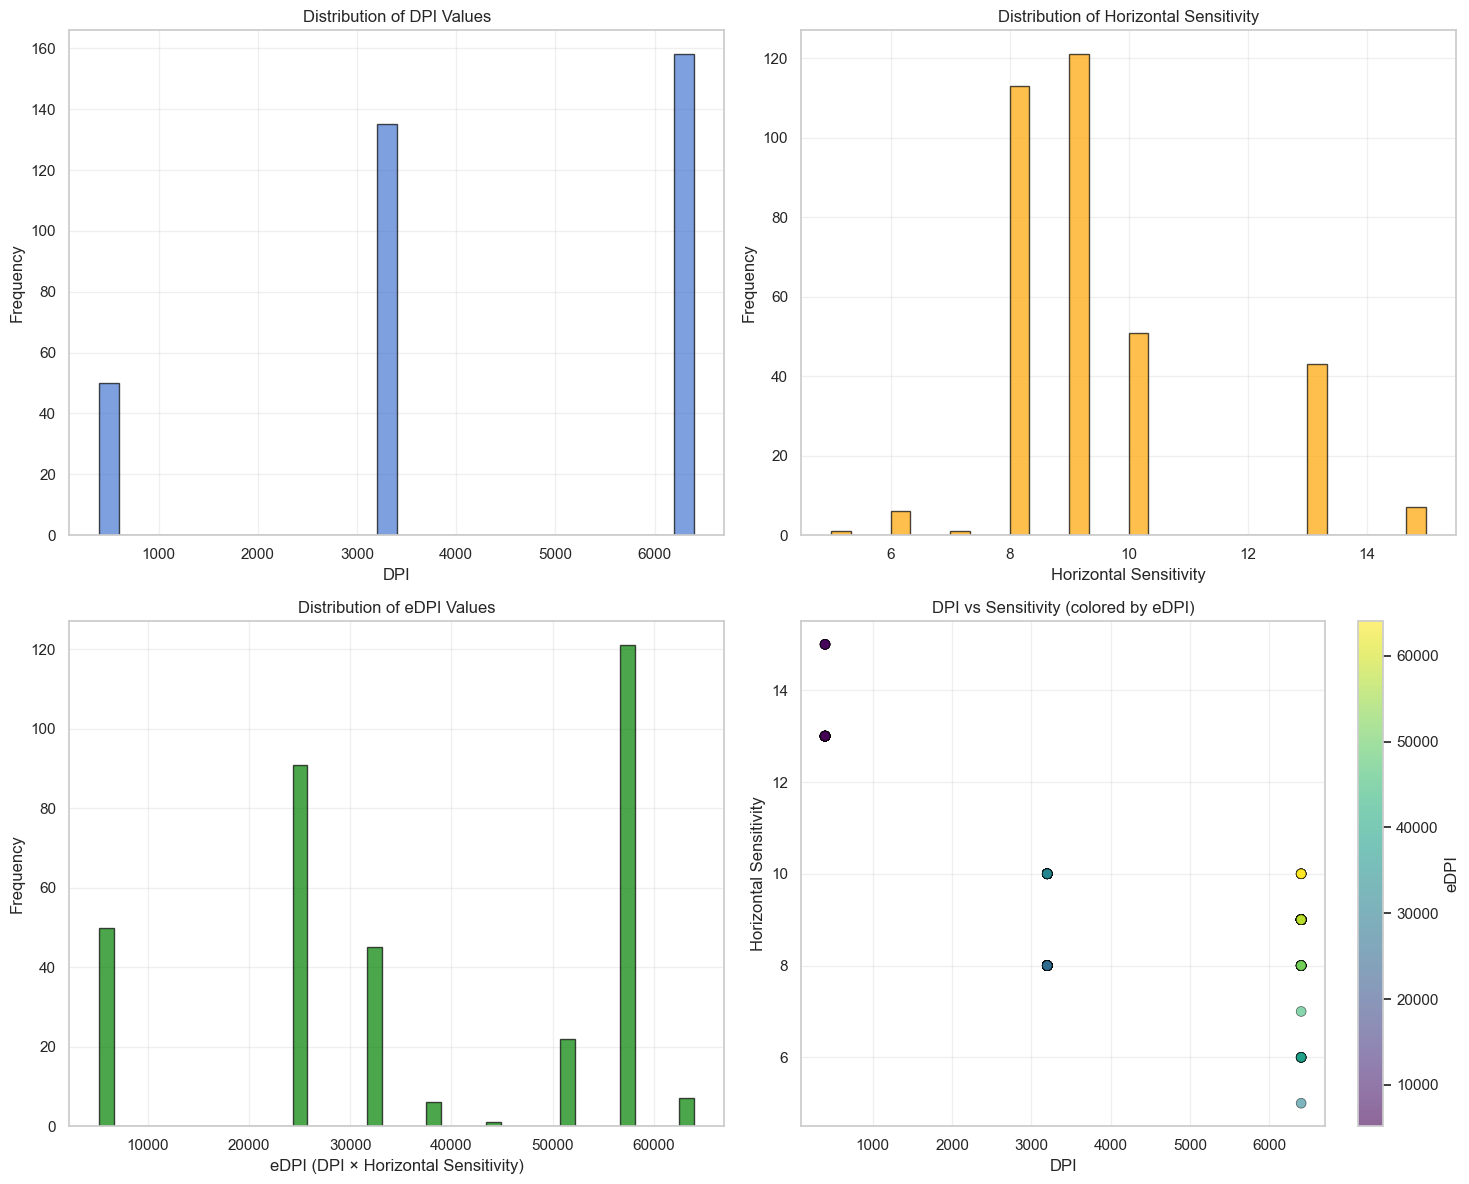

In [ ]:
# Visualization 1: Distribution of sensitivity combinations
sns.set(style="whitegrid", palette="muted")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribution of DPI
axes[0, 0].hist(sens_df['DPI'].dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('DPI')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of DPI Values')
axes[0, 0].grid(True, alpha=0.3)

# dist of h sens
axes[0, 1].hist(sens_df['Horiz Sens'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Horizontal Sensitivity')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Horizontal Sensitivity')
axes[0, 1].grid(True, alpha=0.3)

# dist of eDPI
axes[1, 0].hist(sens_df['eDPI'].dropna(), bins=40, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_xlabel('eDPI (DPI × Horizontal Sensitivity)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of eDPI Values')
axes[1, 0].grid(True, alpha=0.3)

# scatter of DPI vs Sensitivity (colored by eDPI)
scatter = axes[1, 1].scatter(sens_df['DPI'], sens_df['Horiz Sens'], 
                             c=sens_df['eDPI'], cmap='viridis', 
                             alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[1, 1].set_xlabel('DPI')
axes[1, 1].set_ylabel('Horizontal Sensitivity')
axes[1, 1].set_title('DPI vs Sensitivity (colored by eDPI)')
plt.colorbar(scatter, ax=axes[1, 1], label='eDPI')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


/var/folders/4c/16pmds6n0331jpl07wp8sp6w0000gn/T/ipykernel_42309/811157181.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(box_data, labels=box_labels)


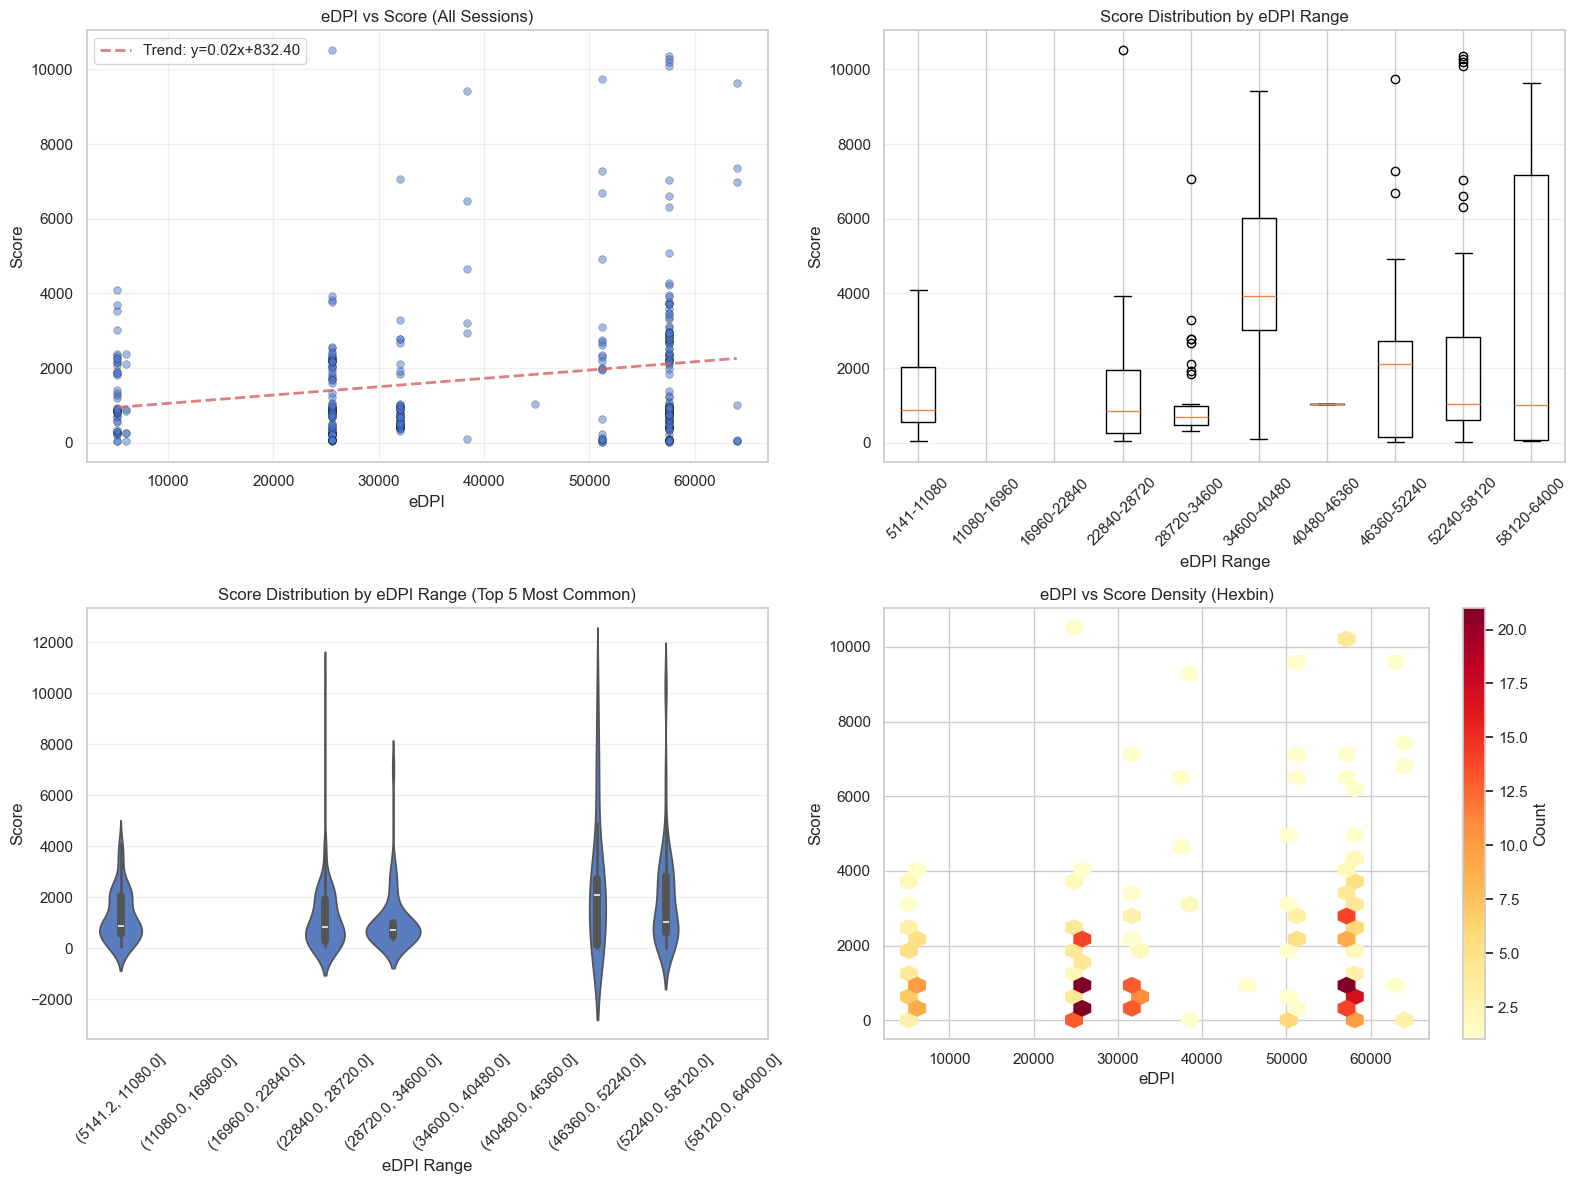

In [ ]:
# eDPI vs Score relationships
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Filter out rows with missing Score
plot_df = sens_df.dropna(subset=['Score', 'eDPI']).copy()

# Scatter plot: eDPI vs Score
axes[0, 0].scatter(plot_df['eDPI'], plot_df['Score'], alpha=0.5, s=30, edgecolors='black', linewidth=0.3)
axes[0, 0].set_xlabel('eDPI')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('eDPI vs Score (All Sessions)')
axes[0, 0].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(plot_df['eDPI'], plot_df['Score'], 1)
p = np.poly1d(z)
axes[0, 0].plot(plot_df['eDPI'].sort_values(), p(plot_df['eDPI'].sort_values()), 
                "r--", alpha=0.8, linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
axes[0, 0].legend()

# Create eDPI bins
plot_df['eDPI_Bin'] = pd.cut(plot_df['eDPI'], bins=10, labels=False)
plot_df['eDPI_Bin_Label'] = pd.cut(plot_df['eDPI'], bins=10)

# Box plot
box_data = [plot_df[plot_df['eDPI_Bin'] == i]['Score'].dropna() for i in range(10)]
box_labels = [f"{interval.left:.0f}-{interval.right:.0f}" for interval in plot_df['eDPI_Bin_Label'].cat.categories]
axes[0, 1].boxplot(box_data, labels=box_labels)
axes[0, 1].set_xlabel('eDPI Range')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Score Distribution by eDPI Range')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Violin plot: Score distribution by eDPI ranges (top 5 most common ranges)
top_edpi_ranges = plot_df['eDPI_Bin_Label'].value_counts().head(5).index
plot_df_top = plot_df[plot_df['eDPI_Bin_Label'].isin(top_edpi_ranges)]
sns.violinplot(data=plot_df_top, x='eDPI_Bin_Label', y='Score', ax=axes[1, 0])
axes[1, 0].set_xlabel('eDPI Range')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Score Distribution by eDPI Range (Top 5 Most Common)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Hexbin plot: eDPI vs Score (shows density)
hb = axes[1, 1].hexbin(plot_df['eDPI'], plot_df['Score'], gridsize=30, cmap='YlOrRd', mincnt=1)
axes[1, 1].set_xlabel('eDPI')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('eDPI vs Score Density (Hexbin)')
plt.colorbar(hb, ax=axes[1, 1], label='Count')

plt.tight_layout()
plt.show()


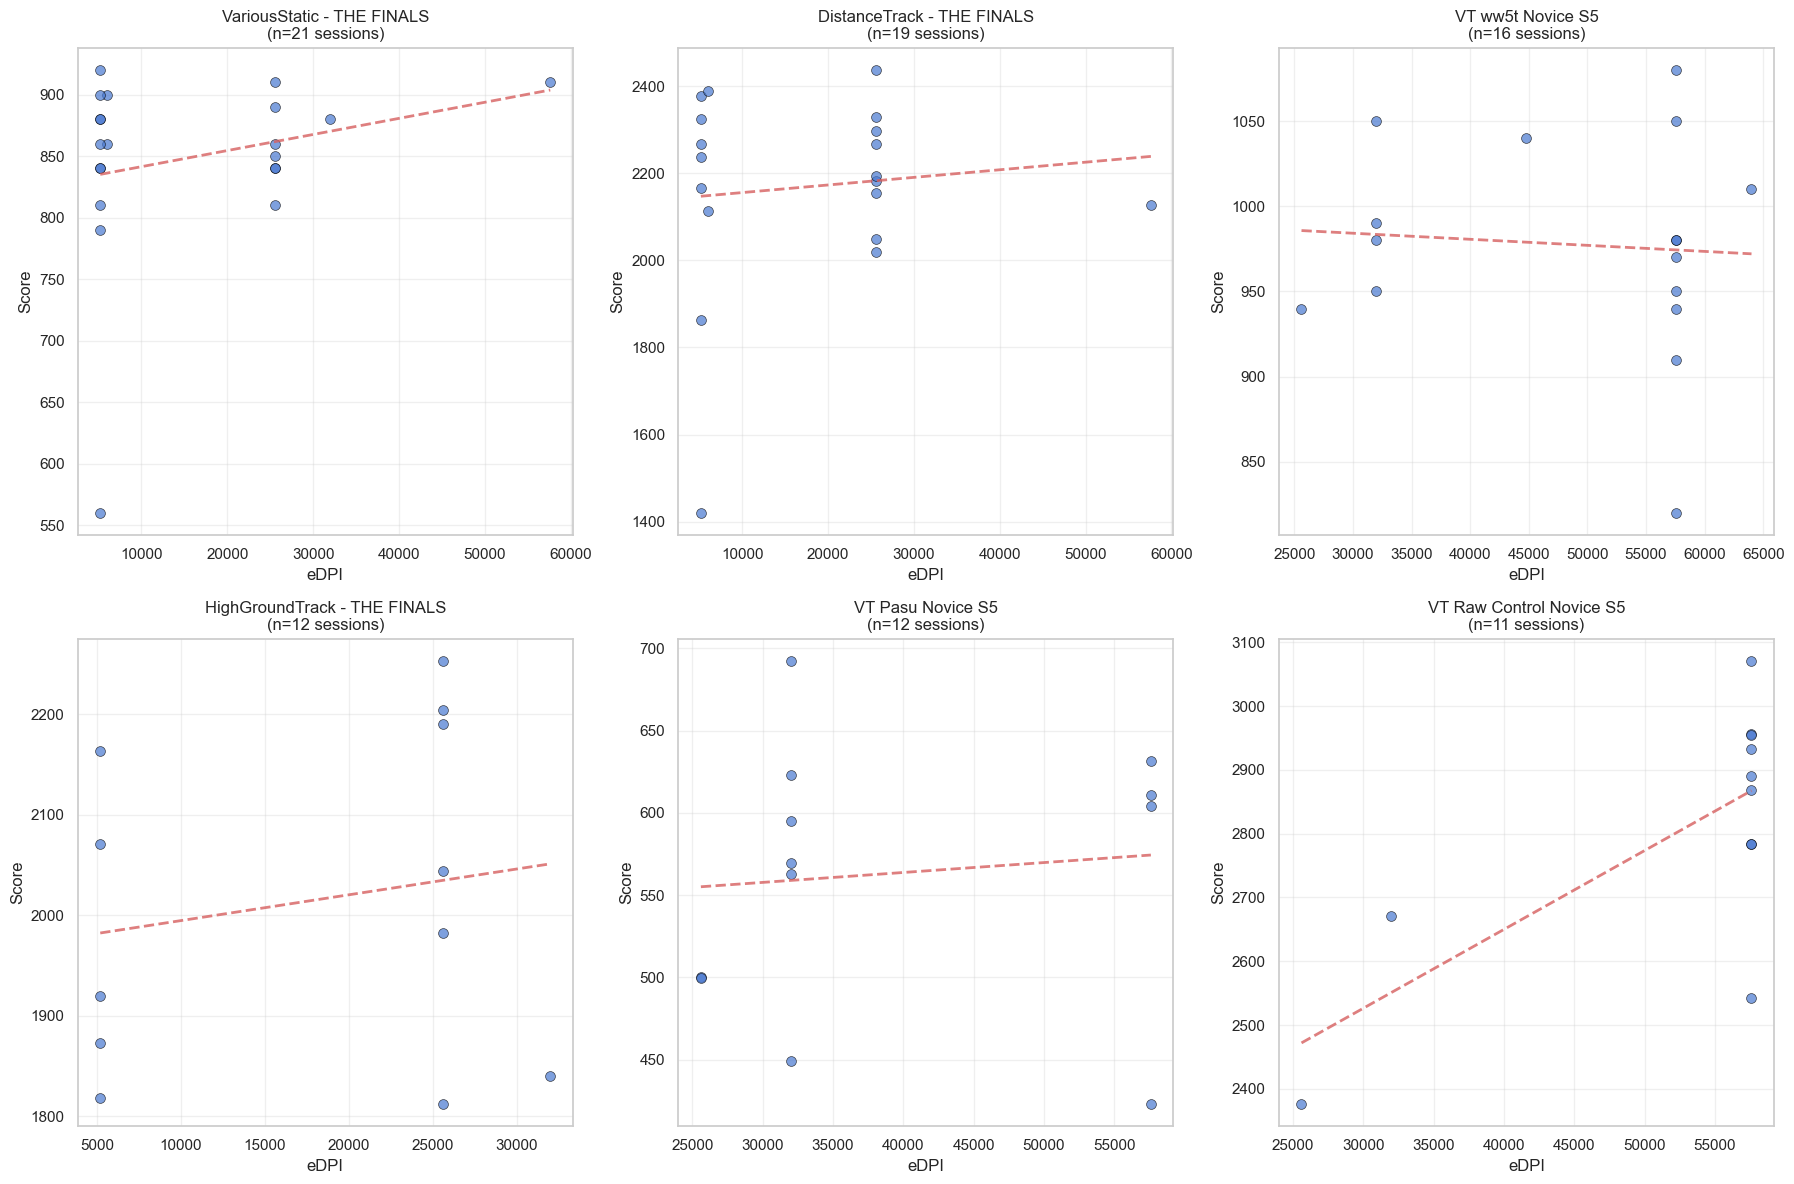

In [ ]:
# Here we are looking at the task specific analysis

# Count sessions per task
task_counts = sens_df.groupby('task').size().sort_values(ascending=False)
high_session_tasks = task_counts[task_counts >= 5].head(6).index.tolist()

if len(high_session_tasks) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, task in enumerate(high_session_tasks):
        task_data = sens_df[sens_df['task'] == task].dropna(subset=['Score', 'eDPI'])
        
        if len(task_data) > 0:
            axes[idx].scatter(task_data['eDPI'], task_data['Score'], 
                            alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
            axes[idx].set_xlabel('eDPI')
            axes[idx].set_ylabel('Score')
            axes[idx].set_title(f'{task}\n(n={len(task_data)} sessions)')
            axes[idx].grid(True, alpha=0.3)
            
            # Add trend line if enough points
            if len(task_data) > 2:
                z = np.polyfit(task_data['eDPI'], task_data['Score'], 1)
                p = np.poly1d(z)
                axes[idx].plot(task_data['eDPI'].sort_values(), 
                             p(task_data['eDPI'].sort_values()), 
                             "r--", alpha=0.8, linewidth=2)
    
    # Hide unused subplots
    for idx in range(len(high_session_tasks), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("No tasks with 5+ sessions found for task-specific analysis")


/var/folders/4c/16pmds6n0331jpl07wp8sp6w0000gn/T/ipykernel_42309/3960490020.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = quartile_df.groupby('eDPI_Quartile')['Score'].agg(['mean', 'median', 'std', 'count'])


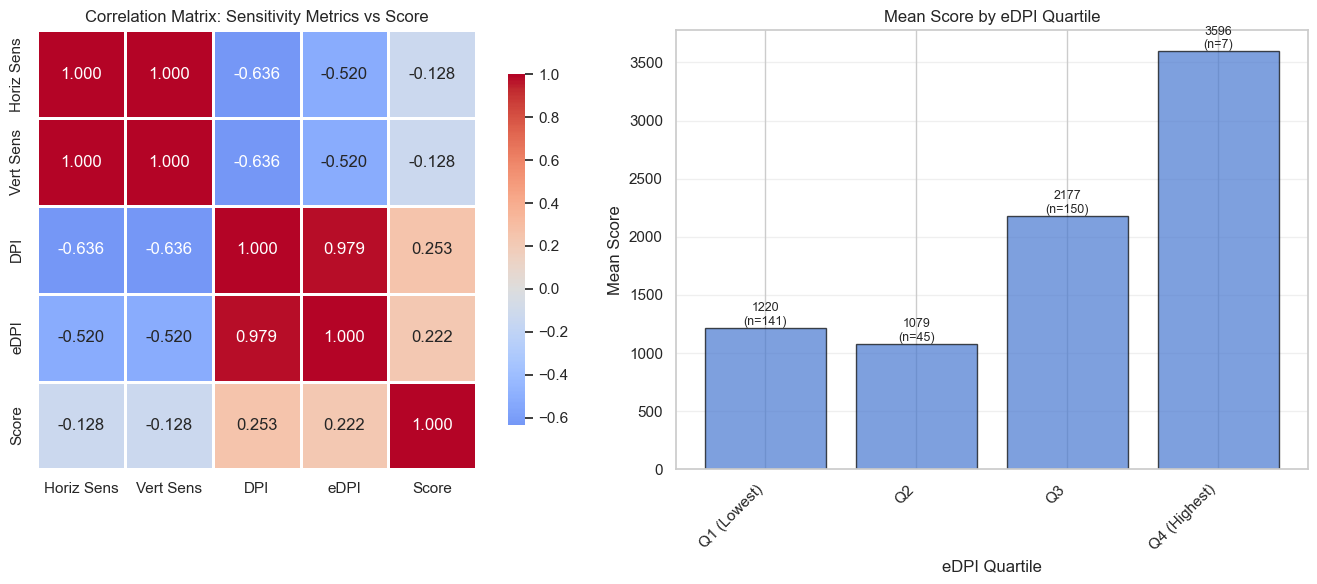


Summary Statistics by eDPI Quartile:
                Mean Score  Median Score      Std Dev  Count
eDPI_Quartile                                               
Q1 (Lowest)    1219.585024         860.0  1243.999927    141
Q2             1078.602026         700.0  1167.060548     45
Q3             2176.789178        1617.0  2263.552008    150
Q4 (Highest)   3595.857143        1010.0  4209.394867      7


In [ ]:
# Correlation analysis and summary statistics
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

corr_cols = ['Horiz Sens', 'Vert Sens', 'DPI', 'eDPI', 'Score']
corr_data = sens_df[corr_cols].corr()
sns.heatmap(corr_data, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, ax=axes[0], cbar_kws={"shrink": 0.8})
axes[0].set_title('Correlation Matrix: Sensitivity Metrics vs Score')

# Summary statistics by eDPI quartiles
# Use sens_df for quartile analysis (need to filter for Score again)
quartile_df = sens_df.dropna(subset=['Score', 'eDPI']).copy()
quartile_df['eDPI_Quartile'] = pd.qcut(quartile_df['eDPI'], q=4, labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)'])
summary_stats = quartile_df.groupby('eDPI_Quartile')['Score'].agg(['mean', 'median', 'std', 'count'])
summary_stats.columns = ['Mean Score', 'Median Score', 'Std Dev', 'Count']

# Bar plot of mean scores by quartile
x_pos = np.arange(len(summary_stats))
axes[1].bar(x_pos, summary_stats['Mean Score'], alpha=0.7, edgecolor='black')
axes[1].set_xlabel('eDPI Quartile')
axes[1].set_ylabel('Mean Score')
axes[1].set_title('Mean Score by eDPI Quartile')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(summary_stats.index, rotation=45, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')

for i, (idx, row) in enumerate(summary_stats.iterrows()):
    axes[1].text(i, row['Mean Score'], f"{row['Mean Score']:.0f}\n(n={int(row['Count'])})", 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics by eDPI Quartile:")
print(summary_stats)


In [ ]:
# Task Categorization System
# Categorize tasks into Flicking, Tracking, and Switching

def categorize_task(task_name):
    """
    Categorize a task into Flicking, Tracking, or Switching based on name patterns.
    
    Returns: category string ('Flicking', 'Tracking', 'Switching', or 'Other')
    """
    task_lower = task_name.lower()
    
    # Manual overrides for specific tasks (add as needed)
    manual_overrides = {
        # add task name overrides here if needed, ---------- probably add some ui feature to do this from user perspective later
        # Example: 'Specific Task Name': 'Flicking'
    }
    
    if task_name in manual_overrides:
        return manual_overrides[task_name]
    
    # CLICKING patterns
    clicking_keywords = [
        'pasu',           # Pasu scenarios
        '1w',             # 1w2ts, 1w3ts, 1w4ts, 1w4t patterns
        '1wall',          # 1wall scenarios
        'ww5t',           # VT ww5t
        'pokeball',       # Pokeball scenarios
        '5 sphere',       # 5 Sphere Hipfire
        'tile frenzy',    # Tile Frenzy
        'flicker',        # Flicker scenarios
    ]
    
    # TRACKING patterns
    tracking_keywords = [
        'track',          # DistanceTrack, HighGroundTrack, etc.
        'smooth',         # Smoothbot, Smoothsphere, Smooth Your Wrist
        'control',        # Raw Control, Controlsphere (but not ControlSwitch)
        'sphere',         # Controlsphere, Smoothsphere
        'air',            # Air scenarios (tracking in air)
        'ground',         # VT Ground
        'leap',           # Leaptrack
        'lock',           # LOCK 90 Snake Track
        'snake track',    # Snake Track scenarios
        'wide angle',     # Wide Angle Tracking
        'pgti',           # PGTI (Precision Ground Tracking Intermediate)
        'pgt',            # PGT (but check it's not switching)
        'zip',            # ZipTrack
        'under',          # UnderTrack
        'pad',            # PadTrack
        'distance',       # DistanceTrack
        'highground',     # HighGroundTrack
        'ascended tracking',  # iiTzTimmy - Ascended Tracking
    ]
    
    # SWITCHING patterns
    switching_keywords = [
        'switch',         # ControlSwitch, HopSwitch, tamTargetSwitch, etc.
        'ts',             # Target Switch (EddieTS, FloatTS, ControlTS, etc.) - but check context
        'popcorn',        # VT Popcorn, Popcorn MV  -  some popcorns are flicking (at least under voltaic, viscose categorizes it as "dynamic clicking")
        'eddie',          # VT EddieTS
        'frogtagon',      # VT Frogtagon
        'penta',          # VT Penta Bounce
        'floating heads', # VT Floating Heads, Floating Heads Timing
        'hopclick',       # HopClick
        'centering',      # Centering II 180 Entry
        'b180',           # B180
        'aether',         # VT Aether
        'variousstatic',  # VariousStatic
        'svgs',           # SVGS
        'bean',           # beanTS
        'dev',            # devTS
        'waldo',          # waldoTS
        'domi',           # domiSwitch
        'vox',            # voxTargetSwitch
        'tam',            # tamTargetSwitch
        'dot',            # VT DotTS
        'fly',            # VT FlyTS
        'float',          # FloatTS (but FloatTS might be switching, not tracking)
    ]
    
    # Check for flicking (check first to avoid conflicts)
    for keyword in flicking_keywords:
        if keyword in task_lower:
            return 'Flicking'
    
    # Check for switching (check before tracking since some TS tasks might be switching)
    for keyword in switching_keywords:
        if keyword in task_lower:
            # Special case: if it's "Controlsphere" it's tracking, not switching
            if 'controlsphere' in task_lower and 'switch' not in task_lower:
                continue
            # Special case: "Smooth" tasks are tracking, not switching
            if 'smooth' in task_lower:
                continue
            return 'Switching'
    
    # Check for tracking
    for keyword in tracking_keywords:
        if keyword in task_lower:
            return 'Tracking'
    
    # Default to Other if no pattern matches
    return 'Other'

# Apply categorization to sens_df
sens_df['Category'] = sens_df['task'].apply(categorize_task)

# Show categorization results
print("Task Categorization Summary:")
print(sens_df['Category'].value_counts())
print(f"\nTotal categorized: {len(sens_df[sens_df['Category'] != 'Other'])}")
print(f"Uncategorized (Other): {len(sens_df[sens_df['Category'] == 'Other'])}")

# Show uncategorized tasks so user can refine
if len(sens_df[sens_df['Category'] == 'Other']) > 0:
    print("\nUncategorized tasks (may need manual categorization):")
    uncategorized = sens_df[sens_df['Category'] == 'Other']['task'].unique()
    for task in sorted(uncategorized):
        print(f"  - {task}")


Task Categorization Summary:
Category
Tracking     141
Switching    135
Flicking      65
Other          2
Name: count, dtype: int64

Total categorized: 341
Uncategorized (Other): 2

Uncategorized tasks (may need manual categorization):
  - KovaaKs Sandbox Intro Scenario
  - Polarized Hell Easy 40% Slower


# Notes:
A **LOT** of these are dependent on how you want to think about it

As a result, it might make sense to either provide different "profiles", so "VT" or "viscose" etc (along with maybe letting the user create a custom profile)

Some amount of these issues get fixed as we get more specific with the subgenre. Additionally, viscose categorization might be easier, since "dynamic clicking" is a bit easier to classify since it is a specific action.

meanwhile voltaic's classification of switching is usually just held clicks against moving targets that die.

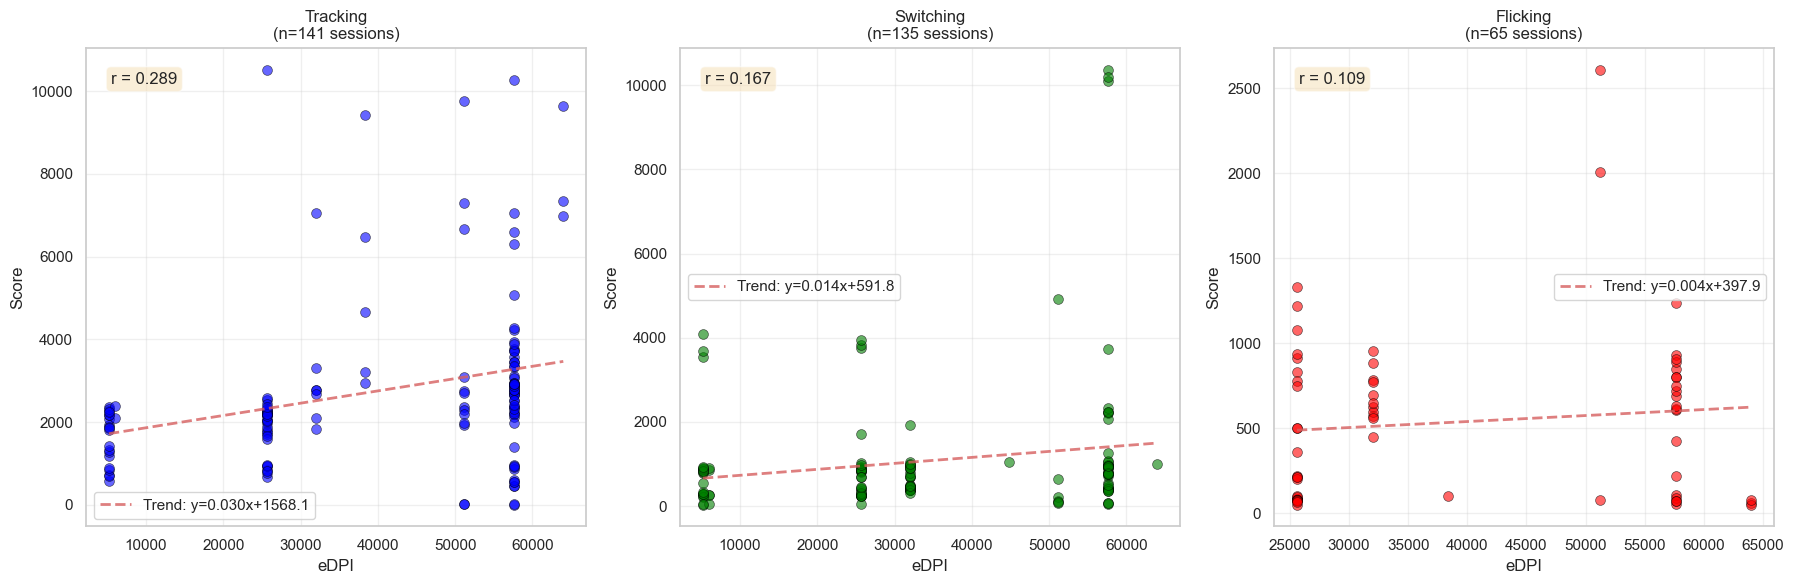


Correlation (eDPI vs Score) by Category:
  Tracking: r = 0.289 (n=141)
  Switching: r = 0.167 (n=135)
  Flicking: r = 0.109 (n=65)


In [ ]:
categories = category_df['Category'].unique()

fig, axes = plt.subplots(1, len(categories), figsize=(6*len(categories), 6))

if len(categories) > 0:
    for idx, cat in enumerate(categories):
        cat_data = category_df[category_df['Category'] == cat]
        
        # Scatter plot with trend line
        axes[idx].scatter(cat_data['eDPI'], cat_data['Score'], 
                         alpha=0.6, s=50, c=colors.get(cat, 'gray'),
                         edgecolors='black', linewidth=0.5)
        axes[idx].set_xlabel('eDPI')
        axes[idx].set_ylabel('Score')
        axes[idx].set_title(f'{cat}\n(n={len(cat_data)} sessions)')
        axes[idx].grid(True, alpha=0.3)
        
        # Add trend line if enough points
        if len(cat_data) > 2:
            z = np.polyfit(cat_data['eDPI'], cat_data['Score'], 1)
            p = np.poly1d(z)
            axes[idx].plot(cat_data['eDPI'].sort_values(), 
                         p(cat_data['eDPI'].sort_values()), 
                         "r--", alpha=0.8, linewidth=2, 
                         label=f'Trend: y={z[0]:.3f}x+{z[1]:.1f}')
            axes[idx].legend()
        
        # Add correlation coefficient
        corr = cat_data['eDPI'].corr(cat_data['Score'])
        axes[idx].text(0.05, 0.95, f'r = {corr:.3f}', 
                      transform=axes[idx].transAxes,
                      verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Accessing important vals, may be more helpful for later user oriented features
print("\nCorrelation (eDPI vs Score) by Category:")
for cat in categories:
    cat_data = category_df[category_df['Category'] == cat]
    corr = cat_data['eDPI'].corr(cat_data['Score'])
    print(f"  {cat}: r = {corr:.3f} (n={len(cat_data)})")


These graphs may be strong

Current results look like what I would expect, my tracking favors my higher sensitivities, (leading to high r value).

meanwhile clicking is benefitting primarily from my improved mouse control as I have gotten used to higher sensitivities (so just general progress related, and time has a sensitivity correlation on my personal data)

/var/folders/4c/16pmds6n0331jpl07wp8sp6w0000gn/T/ipykernel_42309/1775372197.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_data = category_df.groupby(['Category', 'eDPI_Quartile'])['Score'].mean().unstack(fill_value=0)
/var/folders/4c/16pmds6n0331jpl07wp8sp6w0000gn/T/ipykernel_42309/1775372197.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_count = category_df.groupby(['Category', 'eDPI_Quartile']).size().unstack(fill_value=0)


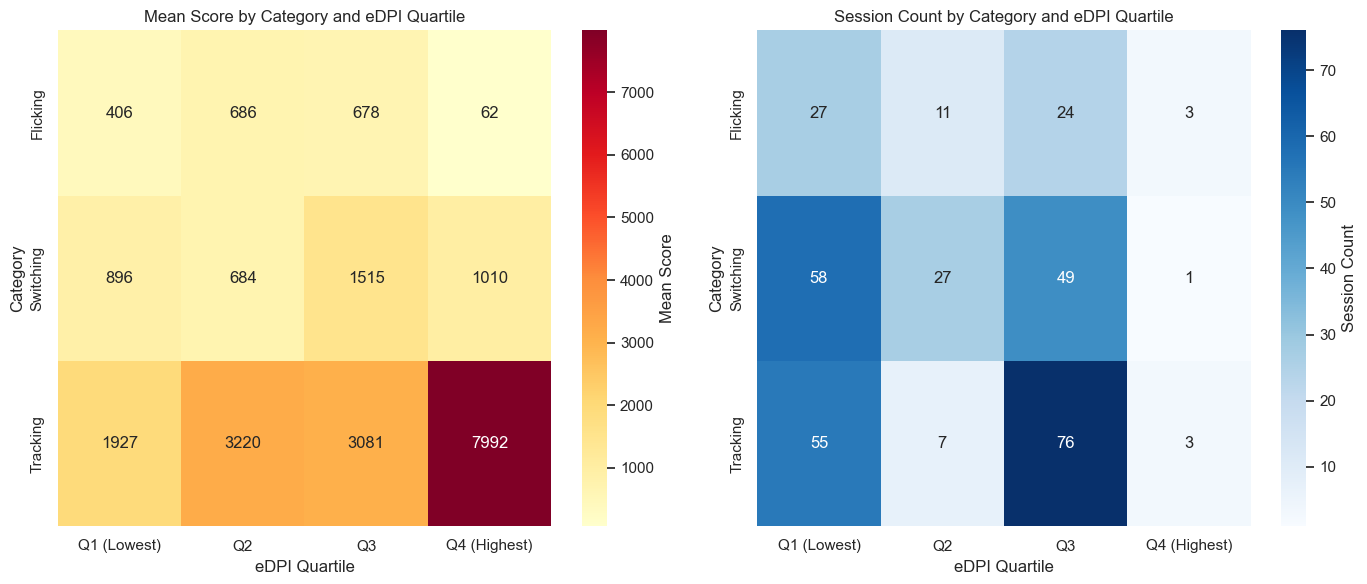


Summary Statistics by Category:

Tracking:
  Sessions: 141
  Mean Score: 2742.5
  Mean eDPI: 39540
  eDPI Range: 5200 - 64000

Switching:
  Sessions: 135
  Mean Score: 1079.0
  Mean eDPI: 34350
  eDPI Range: 5200 - 64000

Flicking:
  Sessions: 65
  Mean Score: 538.0
  Mean eDPI: 39680
  eDPI Range: 25600 - 64000


In [13]:
# Visualization 7: eDPI quartiles by category
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Mean Score by Category and eDPI Quartile
category_df['eDPI_Quartile'] = pd.qcut(category_df['eDPI'], q=4, 
                                       labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)'])

# Create pivot table for heatmap
pivot_data = category_df.groupby(['Category', 'eDPI_Quartile'])['Score'].mean().unstack(fill_value=0)
sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd', 
           ax=axes[0], cbar_kws={'label': 'Mean Score'})
axes[0].set_title('Mean Score by Category and eDPI Quartile')
axes[0].set_xlabel('eDPI Quartile')
axes[0].set_ylabel('Category')

# 2. Count of sessions by Category and eDPI Quartile
pivot_count = category_df.groupby(['Category', 'eDPI_Quartile']).size().unstack(fill_value=0)
sns.heatmap(pivot_count, annot=True, fmt='d', cmap='Blues', 
           ax=axes[1], cbar_kws={'label': 'Session Count'})
axes[1].set_title('Session Count by Category and eDPI Quartile')
axes[1].set_xlabel('eDPI Quartile')
axes[1].set_ylabel('Category')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics by Category:")
for cat in categories:
    cat_data = category_df[category_df['Category'] == cat]
    print(f"\n{cat}:")
    print(f"  Sessions: {len(cat_data)}")
    print(f"  Mean Score: {cat_data['Score'].mean():.1f}")
    print(f"  Mean eDPI: {cat_data['eDPI'].mean():.0f}")
    print(f"  eDPI Range: {cat_data['eDPI'].min():.0f} - {cat_data['eDPI'].max():.0f}")


# Some thoughts:

While DPI might be important, its up to the user to keep it matching the DPI on their mouse, so it can be inaccurate. On my input data I forgot to change the DPI (default is 400) so creates a stronger upward on the eDPI score relationship.

In the app I am thinking there should either be some way to correct previous scores or just use sensitivity instead? Or maybe drop certain ranges of values

Even in my limited dataset, the sensitivity that has been used seems to have decent distributions, should lead to good data in this type of analysis

# things that need to be further refined

Currently I am checking the sens / edpi against the scores, but diff tasks will have diff ranges for the score.

Maybe this could be fixed by just adding a standardized score column? or maybe creating different graphs for different task types (like pasu may need different sens than tracking, switching, etc)